In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
# 먼저 GPU 서버를 켜놓는다. GPU 서버의 Embedding 모델을 활용해야 하기 때문.
GPU_URL = "http://222.107.238.44:8109/v1" #GPU 서버 URL 및 포트, 형식: http://some_url:8109
DB_URL = "here_law_admin:1234@localhost:5434/here_law" #DB URL. 형식: 계정이름:비밀번호@도메인:포트/사용할 DB 이름
COLLECTION_NAME = "case_vector" #판례 데이터

In [3]:
import torch
from embedding_proxy import EmbeddingProxy
from langchain_postgres import PGVector
from langchain.tools.retriever import create_retriever_tool

embedder = EmbeddingProxy(url=GPU_URL)


In [4]:

connection = "postgresql+psycopg://" + DB_URL

vector_store = PGVector(
    embeddings=embedder,
    collection_name=COLLECTION_NAME,
    connection=connection,
    use_jsonb=True,
)

case_retriever = vector_store.as_retriever()

In [5]:
case_retriever.invoke("프로젝트 관련")

ValidationError: 1 validation error for RootModel[List[List[float]]]
  Input should be a valid array [type=list_type, input_value={'detail': 'Not Found'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/list_type

In [6]:
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

In [7]:
retriever_tool = create_retriever_tool(
    case_retriever,
    "korean_rag_case_search",
    "판례 RAG 검색기입니다. user의 상황을 설명하는 한국어 query를 제공하면 비슷한 상황의 판례를 검색하여 제공합니다.",
)
tools = [retriever_tool]

In [8]:
proxy_args = {
    "api_key" : "sk-proj-1pGHnq8uFfaPqRQUWCdgT3BlbkFJ9uF478M8oyptDikjRI7o",
    # "model" : "gpt-4o",
    "model" : "functionary_3.2_KR_custom",
    "base_url" : GPU_URL
}

In [9]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [10]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class HereLawChatbotState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [11]:
MESSAGE_USER_ON_EMPTY_RESPONSE = "Respond with a real output."

In [12]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable
        self.state = None

    def __call__(self, state: HereLawChatbotState, config: RunnableConfig):
        if self.state is None:
            self.state = state
        else:
            self.state = {**self.state, "messages" : self.state["messages"] + state["messages"]}
        temp_state = self.state
        while True:
            result = self.runnable.invoke(temp_state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = temp_state["messages"] + [("user", MESSAGE_USER_ON_EMPTY_RESPONSE)]
                temp_state = {**state, "messages": messages}
            else:
                break            
            # if not result.tool_calls and (
            #     not result.content
            #     or isinstance(result.content, list)
            #     and not result.content[0].get("text")
            # ):
            #     messages = state["messages"] + [("user", MESSAGE_USER_ON_EMPTY_RESPONSE)]
            #     state = {**state, "messages": messages}
            #     messages = state["messages"] + [("user", MESSAGE_USER_ON_EMPTY_RESPONSE)]
            #     state = {**state, "messages": messages}
            # else:
            #     break
        return {"messages": result}
    
    # def __call__(self, state: HereLawChatbotState, config: RunnableConfig):
    #     if self.state is None:
    #         self.state = state
    #     while True:
    #         configuration = config.get("configurable", {}) #>???
    #         # self.state = {**state, "user_info": passenger_id}
    #         result = self.runnable.invoke(self.state)
    #         # If the LLM happens to return an empty response, we will re-prompt it
    #         # for an actual response.
    #         if not result.tool_calls and (
    #             not result.content
    #             or isinstance(result.content, list)
    #             and not result.content[0].get("text")
    #         ):
    #             messages = state["messages"] + [("user", MESSAGE_USER_ON_EMPTY_RESPONSE)]
    #             state = {**state, "messages": messages}
    #         else:
    #             break
    #     return {"messages": result}


# llm = ChatOpenAI(model="gpt-4-turbo-preview")

assistant_prompt = ChatPromptTemplate([("system", "You are an assistant for legal-question-answering tasks. \
                                     If you don't know the answer, just say that you don't know. \
                                     for all responses which is not a function execution, use polite korean and add (all\n) without parenthesis in front of your output."
                                    #  +"\nwhen you use RAG tools to answer the question, you MUST notify user the RAG result(starting as like: _을 수행한 결과입니다:\n_)\
                                    #     and you MUST answer based on most relevant result among them"
                                    
                                    ),
                                    ("placeholder", "{messages}"),
                                    ])

assitant_runnable = ChatOpenAI(temperature=0.1, streaming=False, **proxy_args)
assistant_chain = assistant_prompt | assitant_runnable.bind_tools(tools)

In [13]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(HereLawChatbotState)


# Define nodes: these do the works
builder.add_node("assistant", Assistant(assistant_chain))
builder.add_node("tools", create_tool_node_with_fallback(tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
agent_graph = builder.compile(checkpointer=memory)

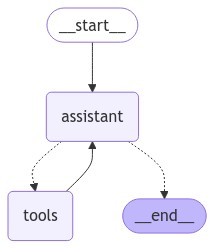

In [14]:
from IPython.display import Image, display

try:
    display(Image(agent_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
import uuid

thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "thread_id": thread_id,
    }
}


_printed = set()


In [18]:

events = agent_graph.stream(
    {"messages": ("user", "차가 뺑소니를 한 뒤에 도망간 경우에 대해 찾아봐")}, config, stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

================================ Human Message =================================

차가 뺑소니를 한 뒤에 도망간 경우에 대해 찾아봐
================================== Ai Message ==================================
Tool Calls:
  korean_rag_case_search (call_IgdOJdkLyywyaB03F7JZyUGO)
 Call ID: call_IgdOJdkLyywyaB03F7JZyUGO
  Args:
    query: 차가 뺑소니를 한 뒤에 도망간
================================= Tool Message =================================
Name: korean_rag_case_search

사고운전자는 교통사고를 낸 후 현장을 떠났으며, 그 사실을 숨기려고 했습니다. 이러한 행동은 법에서 말하는 '도주'에 해당한다고 볼 수 있습니다. 결국 배심원단은 이러한 정황을 고려하여 결정을 내렸습니다.

이 사건은 도로에서 발생한 교통사고와 관련된 상황입니다. 사고 후 자동차의 운전자가 피해자를 돕지 않고 그 자리에서 도주한 경우, 해당 운전자는 법적으로 처벌을 받을 수 있는 상황입니다. 하지만 법에 따르면, 이러한 도주 행위는 별도의 범죄로 간주되지 않고 기존의 사고로 인한 범죄에 포함된다고 설명되고 있습니다. 

배심원들은 이 사건에 대해 논의한 결과, 운전자가 피해자를 도와주지 않고 도주한 점에서 법을 위반했다는 이유로 처벌이 필요하다는 결정을 내렸습니다.

한 운전자가 교차로에서 손수레를 피하기 위해 중앙선을 약간 넘었다. 그는 뒤에서 오는 차량이 교통법규를 지키고 있을 것이라고 믿고 행동했다. 이 후방차량은 무리하게 추월을 시도하면서 사고를 일으켰고, 이에 대해 운전자는 주의 부족이 없다고 주장했다. 결국 배심원은 후방 차량 운전자가 무모하게 운전한 책임이 크다고

AttributeError: 'dict' object has no attribute 'messages'

In [21]:
msgs = agent_graph.get_state(config)

In [24]:
msgs.values["messages"]

[HumanMessage(content='차가 뺑소니를 한 뒤에 도망간 경우에 대해 찾아봐', additional_kwargs={}, response_metadata={}, id='8fc81160-c28a-4b0f-ace5-8db9f711c25f'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_IgdOJdkLyywyaB03F7JZyUGO', 'function': {'arguments': '{"query": "차가 뺑소니를 한 뒤에 도망간"}', 'name': 'korean_rag_case_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': None, 'model_name': 'functionary3.2', 'system_fingerprint': None, 'finish_reason': 128009, 'logprobs': None}, id='run-85908932-0c8b-427f-a7ea-b3e7bf7dd3c5-0', tool_calls=[{'name': 'korean_rag_case_search', 'args': {'query': '차가 뺑소니를 한 뒤에 도망간'}, 'id': 'call_IgdOJdkLyywyaB03F7JZyUGO', 'type': 'tool_call'}]),
 ToolMessage(content="사고운전자는 교통사고를 낸 후 현장을 떠났으며, 그 사실을 숨기려고 했습니다. 이러한 행동은 법에서 말하는 '도주'에 해당한다고 볼 수 있습니다. 결국 배심원단은 이러한 정황을 고려하여 결정을 내렸습니다.\n\n이 사건은 도로에서 발생한 교통사고와 관련된 상황입니다. 사고 후 자동차의 운전자가 피해자를 돕지 않고 그 자리에서 도주한 경우, 해당 운전자는 법적으로 처벌을 받을 수 있는 상황입니다. 하지만 법에 따르면, 이러한 도주 행위는 별도의 범죄로 간주되지 않고 기존